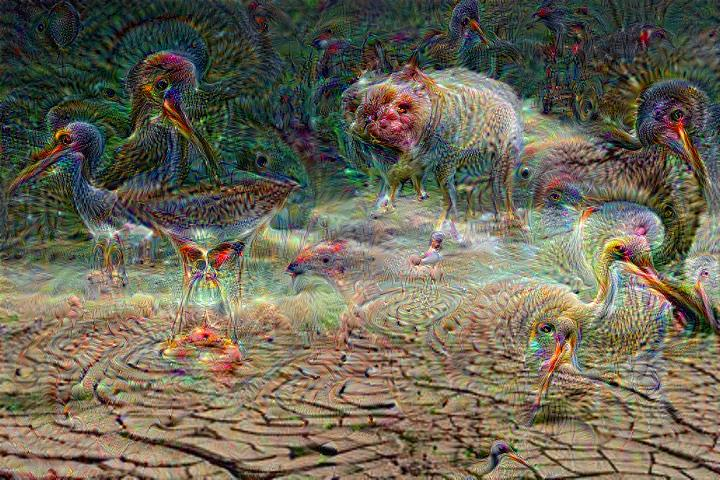

In [15]:
# imports and basic notebook setup
from cStringIO import StringIO
import numpy as np
import scipy.ndimage as nd
import PIL.Image
from IPython.display import clear_output, Image, display
from google.protobuf import text_format
from scipy import ndimage, misc
import matplotlib.pyplot as plt
import random
import caffe
import os
# If your GPU supports CUDA and Caffe was built with CUDA support,
# uncomment the following to run Caffe operations on the GPU.
# caffe.set_mode_gpu()
# caffe.set_device(0) # select GPU device if multiple devices exist

def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = StringIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))
    
model_path = '../caffe/models/bvlc_googlenet/' # substitute your path here
net_fn   = model_path + 'deploy.prototxt'
param_fn = model_path + 'bvlc_googlenet.caffemodel'

# Patching model to be able to compute gradients.
# Note that you can also manually add "force_backward: true" line to "deploy.prototxt".
model = caffe.io.caffe_pb2.NetParameter()
text_format.Merge(open(net_fn).read(), model)
model.force_backward = True
open('tmp.prototxt', 'w').write(str(model))

net = caffe.Classifier('tmp.prototxt', param_fn,
                       mean = np.float32([104.0, 116.0, 122.0]), # ImageNet mean, training set dependent
                       channel_swap = (2,1,0)) # the reference model has channels in BGR order instead of RGB

# a couple of utility functions for converting to and from Caffe's input image layout
def preprocess(net, img):
    return np.float32(np.rollaxis(img, 2)[::-1]) - net.transformer.mean['data']
def deprocess(net, img):
    return np.dstack((img + net.transformer.mean['data'])[::-1])  
def objective_L2(dst):
    dst.diff[:] = dst.data 

def make_step(net, step_size=1.5, end='inception_4c/output', 
              jitter=32, clip=True, objective=objective_L2):
    '''Basic gradient ascent step.'''

    src = net.blobs['data'] # input image is stored in Net's 'data' blob
    dst = net.blobs[end]

    ox, oy = np.random.randint(-jitter, jitter+1, 2)
    src.data[0] = np.roll(np.roll(src.data[0], ox, -1), oy, -2) # apply jitter shift
            
    net.forward(end=end)
    objective(dst)  # specify the optimization objective
    net.backward(start=end)
    g = src.diff[0]
    # apply normalized ascent step to the input image
    src.data[:] += step_size/np.abs(g).mean() * g

    src.data[0] = np.roll(np.roll(src.data[0], -ox, -1), -oy, -2) # unshift image
            
    if clip:
        bias = net.transformer.mean['data']
        src.data[:] = np.clip(src.data, -bias, 255-bias)  
def deepdream(net, base_img, iter_n=10, octave_n=4, octave_scale=1.4, 
              end='inception_4c/output', clip=True, **step_params):
    # prepare base images for all octaves
    octaves = [preprocess(net, base_img)]
    for i in xrange(octave_n-1):
        octaves.append(nd.zoom(octaves[-1], (1, 1.0/octave_scale,1.0/octave_scale), order=1))
    
    src = net.blobs['data']
    detail = np.zeros_like(octaves[-1]) # allocate image for network-produced details
    for octave, octave_base in enumerate(octaves[::-1]):
        h, w = octave_base.shape[-2:]
        if octave > 0:
            # upscale details from the previous octave
            h1, w1 = detail.shape[-2:]
            detail = nd.zoom(detail, (1, 1.0*h/h1,1.0*w/w1), order=1)

        src.reshape(1,3,h,w) # resize the network's input image size
        src.data[0] = octave_base+detail
        for i in xrange(iter_n):
            make_step(net, end=end, clip=clip, **step_params)
            
            # visualization
            vis = deprocess(net, src.data[0])
            if not clip: # adjust image contrast if clipping is disabled
                vis = vis*(255.0/np.percentile(vis, 99.98))
            showarray(vis)
            print octave, i, end, vis.shape
            clear_output(wait=True)
            
        # extract details produced on the current octave
        detail = src.data[0]-octave_base
    # returning the resulting image
    return deprocess(net, src.data[0])  
# Goal (320, 240)
guide0 = np.float32(PIL.Image.open('300spider.jpg'))
end = 'inception_5a/pool'
h, w = guide0.shape[:2]
src, dst = net.blobs['data'], net.blobs[end]
src.reshape(1,3,h,w)
src.data[0] = preprocess(net, guide0)
net.forward(end=end)
guide_features = dst.data[0].copy()
def objective_guide(dst):
    x = dst.data[0].copy()
    y = guide_features
    ch = x.shape[0]
    x = x.reshape(ch,-1)
    y = y.reshape(ch,-1)
    A = x.T.dot(y) # compute the matrix of dot-products with guide features
    dst.diff[0].reshape(ch,-1)[:] = y[:,A.argmax(1)] # select ones that match best
    
    
def center_crop(img, new_width=None, new_height=None):        
    width = img.shape[1]
    height = img.shape[0]
    if new_width is None:
        new_width = min(width, height)
    if new_height is None:
        new_height = min(width, height)
    left = int(np.ceil((width - new_width) / 2))
    right = width - int(np.floor((width - new_width) / 2))
    top = int(np.ceil((height - new_height) / 2))
    bottom = height - int(np.floor((height - new_height) / 2))
    if len(img.shape) == 2:
        center_cropped_img = img[top:bottom, left:right]
    else:
        center_cropped_img = img[top:bottom, left:right, ...]
    return center_cropped_img
#path = r"image_resources/"
#base_image = random.choice([
#    x for x in os.listdir(path)
#    if os.path.isfile(os.path.join(path, x))
#])
filename0=(path+base_image)


_ = np.float32(PIL.Image.open(filename0))
new_width=720   
new_height=480
#nimage = center_crop(img, new_width, new_height)



cnt =0
s = 0.02 # scale coefficient
h, w = _.shape[:2]
_=deepdream(net, _, iter_n=20, end='inception_5a/3x3_reduce')
_=deepdream(net, _, iter_n=20, end='inception_4d/pool_proj', objective=objective_guide)
img_rot = nd.rotate(_, .2, reshape=True)
img= nd.affine_transform(img_rot, [1-s,1-s,1], [h*s/2,w*s/2,0], order=1)
nimage = center_crop(img, new_width, new_height)
#img =nimage.resize((720,480))
PIL.Image.fromarray(np.uint8(img)).save("result0.jpg")
nimage = PIL.Image.open("result0.jpg")
img = nimage.resize((720,480))
img.save("result.png")



showarray(_)
 

In [18]:
im = PIL.Image.open("result.jpg")
print(im.size)
im

(720, 480)


<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=720x480 at 0x7F9E0C82CFC8>

In [6]:
!ls

All-In One.ipynb			   dream-Copy2.ipynb
DEEP-DREAM-ONLY.ipynb			   dream-this.jpg
Dream-One-Image.ipynb			   dream-this.png
GoogLeNet_cars.ipynb			   dream.ipynb
Untitled.ipynb				   image_resources
bvlc_alexnet-Experiments-checkpoint.ipynb  original.caffemodel
bvlc_googlenet				   placesCNN
bvlc_reference_caffenet			   tmp.prototxt
dream-Copy1.ipynb


In [4]:
!ls ../

caffe  deepdream  start.sh


In [4]:
!ls ../caffe/models/GoogLeNet_cars

0001.jpg  0027.jpg  0053.jpg  0079.jpg
0002.jpg  0028.jpg  0054.jpg  0080.jpg
0003.jpg  0029.jpg  0055.jpg  0081.jpg
0004.jpg  0030.jpg  0056.jpg  0082.jpg
0005.jpg  0031.jpg  0057.jpg  0083.jpg
0006.jpg  0032.jpg  0058.jpg  0084.jpg
0007.jpg  0033.jpg  0059.jpg  0085.jpg
0008.jpg  0034.jpg  0060.jpg  0086.jpg
0009.jpg  0035.jpg  0061.jpg  0087.jpg
0010.jpg  0036.jpg  0062.jpg  0088.jpg
0011.jpg  0037.jpg  0063.jpg  0089.jpg
0012.jpg  0038.jpg  0064.jpg  0090.jpg
0013.jpg  0039.jpg  0065.jpg  0091.jpg
0014.jpg  0040.jpg  0066.jpg  0092.jpg
0015.jpg  0041.jpg  0067.jpg  0093.jpg
0016.jpg  0042.jpg  0068.jpg  0094.jpg
0017.jpg  0043.jpg  0069.jpg  0095.jpg
0018.jpg  0044.jpg  0070.jpg  0096.jpg
0019.jpg  0045.jpg  0071.jpg  0097.jpg
0020.jpg  0046.jpg  0072.jpg  0098.jpg
0021.jpg  0047.jpg  0073.jpg  0099.jpg
0022.jpg  0048.jpg  0074.jpg  0100.jpg
0023.jpg  0049.jpg  0075.jpg  cars-deploy.prototxt
0024.jpg  0050.jpg  0076.jpg  googlenet_finetune_web_car_iter_10000.caffemodel
0025.jpg  00

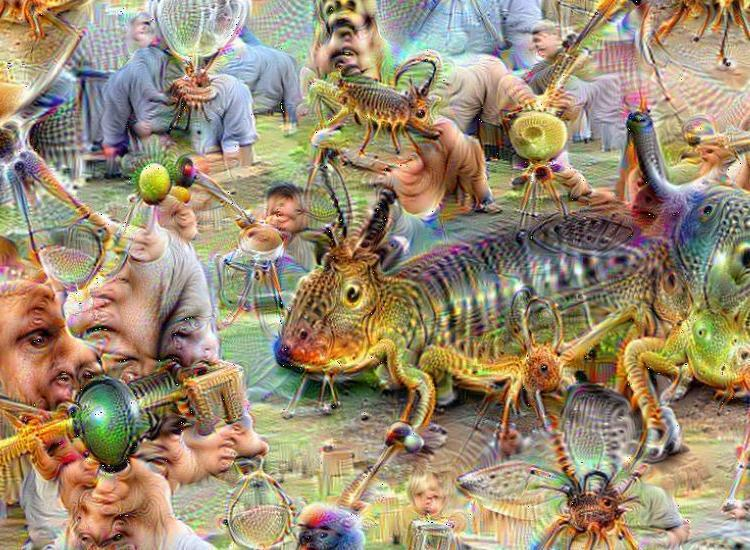

In [2]:
_ = np.float32(PIL.Image.open('REsized.jpg'))
new_width=750   
new_height=550
#nimage = center_crop(img, new_width, new_height)



cnt =0
s = 0.02 # scale coefficient
h, w = _.shape[:2]
_=deepdream(net, _, iter_n=20, end='inception_5a/3x3_reduce')
_=deepdream(net, _, iter_n=20, end='inception_4d/pool_proj', objective=objective_guide)
img_rot = nd.rotate(_, .2, reshape=True)
img= nd.affine_transform(img_rot, [1-s,1-s,1], [h*s/2,w*s/2,0], order=1)
nimage = center_crop(img, new_width, new_height)
PIL.Image.fromarray(np.uint8(nimage)).save("FILES/750x551_"+str(cnt)+"_.jpg")
_=img
cnt =cnt+1



showarray(_)

In [ ]:

new_width=750   
new_height=550
#nimage = center_crop(img, new_width, new_height)



cnt =0
s = 0.02 # scale coefficient
h, w = _.shape[:2]
for i in xrange(1000):
    _=deepdream(net, _, iter_n=20, end='inception_5a/3x3_reduce')
    _=deepdream(net, _, iter_n=20, end='inception_4d/pool_proj', objective=objective_guide)

    img_rot = nd.rotate(_, .2, reshape=True)
    img= nd.affine_transform(img_rot, [1-s,1-s,1], [h*s/2,w*s/2,0], order=1)
    nimage = center_crop(img, new_width, new_height)
    PIL.Image.fromarray(np.uint8(nimage)).save("FILES/750x551_"+str(cnt)+"_.jpg")
    _=img
    cnt =cnt+1

In [34]:
!ls TAROT/*.jpg > TAROT.list


In [48]:
def DREAM(_,cnt):
    s = 0.02 # scale coefficient
    h, w = _.shape[:2]
    _=deepdream(net, _,  iter_n=20, end='inception_5a/3x3_reduce')
    _= nd.affine_transform(_, [1-s,1-s,1], [h*s/2,w*s/2,0], order=1)
    _=deepdream(net, _,  iter_n=20, end='inception_4d/pool_proj', objective=objective_guide)
    _= nd.affine_transform(_, [1-s,1-s,1], [h*s/2,w*s/2,0], order=1)
    _=deepdream(net, _,  iter_n=20, end='inception_5a/3x3_reduce')
    _= nd.affine_transform(_, [1-s,1-s,1], [h*s/2,w*s/2,0], order=1)
    _=deepdream(net, _,  iter_n=20, end='inception_5b/output')
    
    PIL.Image.fromarray(np.uint8(_)).save("TAROT/_"+str(cnt)+"_.jpg")
 

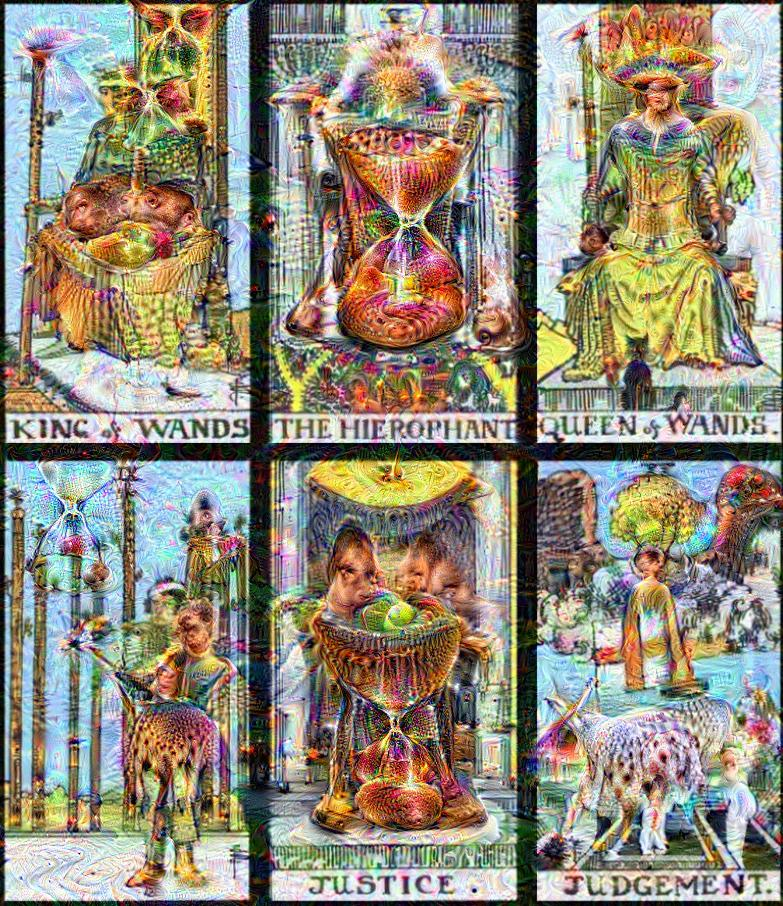

3 19 inception_5b/output (906, 783, 3)


In [49]:
files =open("TAROT.list", "r").readlines()
cnt = 0
for imagepath in files:
    cnt=cnt+1
    imagepath=imagepath.replace("\n","")
    print(imagepath)
    _ = np.float32(PIL.Image.open(imagepath))
    DREAM(_,cnt)
    